In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import scipy
import scipy.stats

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


In [3]:
from sklearn import linear_model
import sklearn.metrics

In [4]:
import Training

`N_CPUS` is the number of CPU cores to use for training. **Do not use more than half your physically installed cores.** Tensorflow appears to struggle with some race conditions if there are too many contesting threads; it doesn't crash and it doesn't skew the results, but it does complain of "excessive graph retracing".

In [5]:
N_CPUS = 2
iterations = 10

In [6]:
tf.config.set_logical_device_configuration(
    tf.config.list_physical_devices('CPU')[0],
    [tf.config.LogicalDeviceConfiguration() for n in range(N_CPUS)]
)

In [7]:
featFileName = "../data/features_combined.csv"
batch_pd = pd.read_csv(featFileName, index_col=False)

In [8]:
bat_info = batch_pd.loc[:,'policy':'cycle_life']
bat_info

,policy,barcode,cycle_life
0,3_6C-80PER_3_6C,???,1189.0
1,3_6C-80PER_3_6C,???,1178.0
2,3_6C-80PER_3_6C,???,1176.0
3,4C-80PER_4C,???,1225.0
4,4C-80PER_4C,???,1226.0
...,...,...,...
75,6C_31PER_4_25C,???,462.0
76,6C_40PER_4C,???,457.0
77,6C_4PER_4_75C,???,487.0
78,6C_52PER_3_5C,???,429.0


In [9]:
feat = batch_pd.drop(['policy','barcode','cycle_life','QDiffLinVar'], axis=1).to_numpy()
feat

array([[ 1.071,  0.468,  1.076, ...,  1.091,  0.   ,  1.072],
       [ 1.075,  0.009,  1.081, ...,  1.081, -0.   ,  1.085],
       [ 1.08 ,  0.008,  1.085, ...,  1.085, -0.   ,  1.089],
       ...,
       [ 1.07 ,  0.005,  1.073, ...,  1.075, -0.   ,  1.081],
       [ 1.073,  0.007,  1.08 , ...,  1.078, -0.   ,  1.081],
       [ 1.042,  0.008,  1.047, ...,  1.049, -0.   ,  1.055]])

In [10]:
# quoted: "data fix"
feat[0,9] = 1.692e-5;
feat[0,10] = 1.0750;

feat[14,1] = 0.00397;
feat[14,9] = -4.8296e-5;
feat[14,10] = 1.0705;

### Data Split
fast-normal charging split and then train-test split

In [11]:
fast_charge_indices = bat_info['policy'].str.match("^[5-8].*C")
slow_charge_feat = feat[~fast_charge_indices]
slow_charge_label = bat_info["cycle_life"][~fast_charge_indices]
fast_charge_feat = feat[fast_charge_indices]
fast_charge_label = bat_info["cycle_life"][fast_charge_indices]

In [12]:
feat_train = slow_charge_feat[0::2]
feat_test = slow_charge_feat[1::2]
label_train = slow_charge_label[0::2]
label_test = slow_charge_label[1::2]

In [13]:
# scale data
feat_train_scaled = scipy.stats.zscore(feat_train)
feat_test_scaled = scipy.stats.zmap(feat_test, feat_train)

## Load Base Model
Load the 'base' model trained on 'fast charging' data subset.

In [14]:
def load_base_model():
    model = keras.models.load_model('../discharge_model/saved_model/DischargeModelFastTF')
    return model

In [15]:
discharge_model_fast = load_base_model()
discharge_model_fast.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


## Generate Base Model Predictions
As the 14th feature

In [16]:
feat_14_train = discharge_model_fast(feat_train_scaled)
feat_14_test = discharge_model_fast(feat_test_scaled)

In [17]:
feat_train_scaled = np.hstack((
    feat_train_scaled, np.log10(np.abs(feat_14_train))
))
feat_test_scaled = np.hstack((
    feat_test_scaled, np.log10(np.abs(feat_14_test))
))

In [18]:
feat_train_scaled.shape

(26, 14)

In [19]:
feat_train_scaled

array([[ 0.79 ,  0.323,  0.933, -1.406, -1.596, -1.415,  1.285, -1.397,
        -0.706,  0.696,  0.777,  0.854,  0.693,  3.037],
       [-0.468,  0.916, -0.209, -1.464, -1.475, -1.358,  0.885,  0.421,
        -1.132,  0.943, -0.552,  0.669, -0.602,  3.027],
       [ 0.601,  1.276,  0.802, -1.559, -1.352, -1.586,  0.083, -0.739,
         0.935,  0.852,  0.612,  0.39 ,  0.77 ,  3.011],
       [-0.971, -0.997, -1.375,  0.246,  0.323,  0.333, -0.746,  0.852,
        -0.702, -1.332, -1.021, -1.599, -0.862,  2.853],
       [-0.294, -1.573, -1.702,  1.651,  1.828,  1.54 ,  0.734, -3.076,
        -3.226, -4.063, -0.309, -4.24 ,  0.147,  2.692],
       [ 0.404, -0.653,  0.34 , -1.245, -1.114, -1.336,  0.23 , -0.703,
         0.793, -0.074,  0.34 ,  0.67 ,  0.066,  3.036],
       [-0.021, -0.531, -0.025, -1.311, -1.351, -1.281,  1.113, -0.552,
         0.76 ,  0.159, -0.102,  0.43 , -0.248,  3.045],
       [ 0.379, -1.008,  0.273, -0.555, -0.62 , -0.537,  0.909, -0.616,
         1.   , -0.188,  

## Model Building
Try three optimization algorithms to train the same model structure  
1. SKLearn ElasticNetCV
2. TensorFlow FTRL
3. TensorFlow ADAM

All three algorithms will be configured to use L1+L2 regularization with similar hyperparameters.

In [20]:
sklearn_transfer_model = linear_model.ElasticNetCV(cv=4, l1_ratio=0.9)

In [21]:
def make_FTRL_transfer_model():
    transfer_model = keras.models.Sequential([
        layers.Dense(units=1,
            activation=layers.LeakyReLU(alpha=0.1)),
        layers.Lambda(lambda x: tf.constant(10.0) ** x)
    ])
    
    # Initialize layer shape to match training batch size
    transfer_model(feat_train_scaled)

    transfer_model.compile(
        optimizer=keras.optimizers.Ftrl(
            learning_rate=0.0005,
            # learning_rate_power=0.0,
            l1_regularization_strength=0.9,
            l2_regularization_strength=0.1
        ),
        loss='mean_squared_error')
    
    return transfer_model

In [22]:
def make_ADAM_transfer_model():
    transfer_model = keras.models.Sequential([
        layers.Dense(units=1,
            kernel_regularizer=keras.regularizers.L1L2(l1=0.9, l2=0.1),
            activation=layers.LeakyReLU(alpha=0.1)),
        layers.Lambda(lambda x: tf.constant(10.0) ** x)
    ])
    
    # Initialize layer shape to match training batch size
    transfer_model(feat_train_scaled)

    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error')
    
    return transfer_model

## Train Models
Note: All models are using early-stopping

In [23]:
cpus = [device.name for device in tf.config.list_logical_devices()]

In [24]:
sklearn_transfer_model.fit(
    feat_train_scaled,
    label_train
)

ElasticNetCV(cv=4, l1_ratio=0.9)

In [25]:
results1 = Training.multithread_train(
    feat_train_scaled,
    label_train,
    feat_test_scaled,
    label_test,
    make_FTRL_transfer_model,
    device_list=np.resize(cpus, 10),
    epochs=5000,
    num_threads=len(cpus)
)

Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:0


In [26]:
results2 = Training.multithread_train(
    feat_train_scaled,
    label_train,
    feat_test_scaled,
    label_test,
    make_ADAM_transfer_model,
    device_list=np.resize(cpus, 10),
    epochs=5000,
    num_threads=len(cpus)
)

Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:0
Training on /device:CPU:1
Training on /device:CPU:2
Training on /device:CPU:0


## Evaluate Models

### SKLearn (Single-Run) RMSE

In [27]:
sklearn.metrics.mean_squared_error(
    label_test,
    sklearn_transfer_model.predict(feat_test_scaled),
    squared=False
)

85.07705464135705

In [28]:
sklearn_transfer_model.n_iter_

37

In [37]:
# the transfer model appears to have dropped the data from the previous model
sklearn_transfer_model.coef_

array([ 18.34 , -31.606,  10.745, -46.896, -45.905, -48.704,  17.368,
       -19.462, -18.555, -12.947,  18.387,  23.656,   0.   ,  -0.   ])

In [38]:
sklearn_transfer_model.intercept_

693.9999999999994

### TensorFlow Per-Run RMSE

In [29]:
FTRL_RMSE = pd.DataFrame(results1)
ADAM_RMSE = pd.DataFrame(results2)

In [30]:
all_RMSE = pd.concat([FTRL_RMSE['RMSE'], ADAM_RMSE['RMSE']], axis=1, keys=['FTRL','ADAM'])
all_RMSE

,FTRL,ADAM
0,681.428188,681.303874
1,671.997094,1080.394777
2,582.389206,1522.578159
3,108906.056544,677.509963
4,662.230676,547.305331
5,669.718528,681.356299
6,659.696332,663.154229
7,682.015602,628.185830
8,69783.544651,623.111071
9,662.984398,607.766094


In [31]:
RMSE_stats = all_RMSE.describe().transpose().drop(['25%', '50%', '75%'], axis=1)
RMSE_stats

,count,mean,std,min,max
FTRL,10.0,18396.206122,38513.418046,582.389206,108906.056544
ADAM,10.0,771.266563,301.108741,547.305331,1522.578159


### Loss Graphs

In [32]:
def plot_loss(history, ylims = [100, 300], ax_names={'loss': 'loss', 'val_loss': 'val_loss'}):
    plt.plot(np.sqrt(history.history['loss']), 'b', label=ax_names['loss'])
    plt.plot(np.sqrt(history.history['val_loss']), 'r', label=ax_names['val_loss'])
    plt.ylim(ylims)
    plt.xlabel('Epoch')
    plt.ylabel('Error [cycles]')
    plt.legend()
    plt.grid(True)
    # plt.show()

Runs of all ten FTRL transfer models overlaid on the same graph

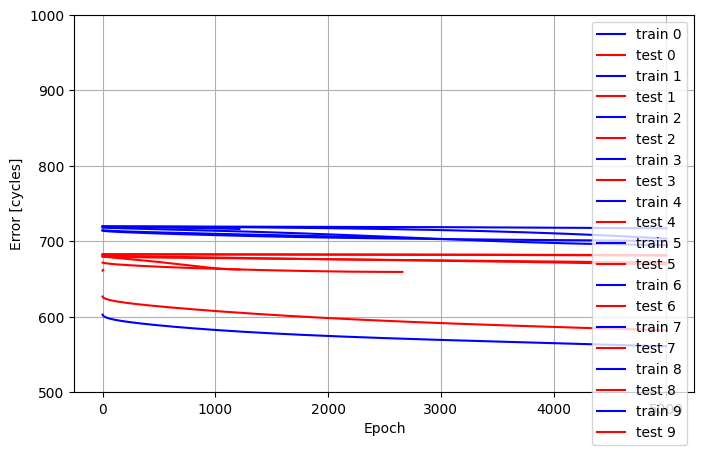

In [33]:
plt.figure('FTRLLoss', figsize=(8,5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(FTRL_RMSE)):
    plot_loss(FTRL_RMSE['history'][i],
        ylims=[500,1000],
        ax_names={
            'loss': 'train '+str(i),
            'val_loss': 'test '+str(i)
        })
plt.show()

Runs of all ten ADAM transfer models overlaid on the same graph

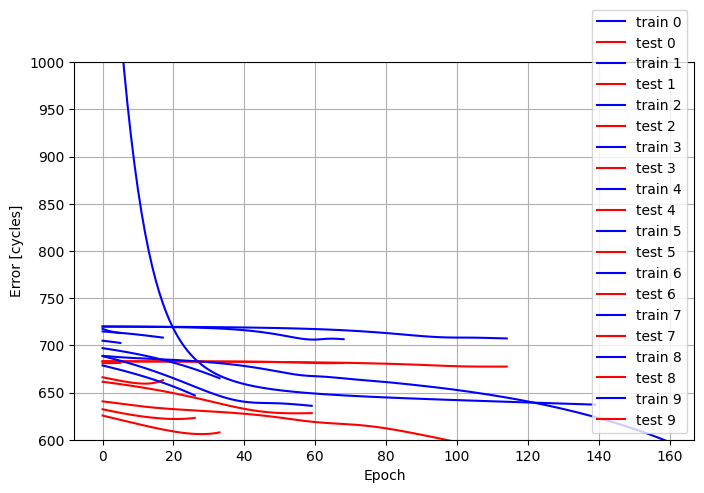

In [34]:
plt.figure('ADAMLoss', figsize=(8,5), dpi=100, facecolor='w', edgecolor='k')
for i in range(len(ADAM_RMSE)):
    plot_loss(ADAM_RMSE['history'][i],
        ylims=[600,1000],
        ax_names={
            'loss': 'train '+str(i),
            'val_loss': 'test '+str(i)
        })
plt.show()